In [11]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


In [3]:
def load_images_and_masks(image_dir, mask_dir, img_size=(128, 128)):
    images, masks = [], []
    for file in os.listdir(image_dir):
        # Load MRI image
        img = cv2.imread(os.path.join(image_dir, file), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, img_size) / 255.0  # Normalize to [0, 1]
        images.append(img)

        # Load corresponding mask
        mask = cv2.imread(os.path.join(mask_dir, file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size) / 255.0  # Normalize to [0, 1]
        masks.append(mask)
    
    return np.array(images), np.array(masks)

# Paths to the dataset
image_dir = 'C:/Users/lenovo/Desktop/brain tumor/images/'
mask_dir = 'C:/Users/lenovo/Desktop/brain tumor/masks/'

# Load data
X, Y = load_images_and_masks(image_dir, mask_dir)

# Add a channel dimension for CNN input
X = X[..., np.newaxis]
Y = Y[..., np.newaxis]

# Split into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

In [5]:
print(X_train.shape)

(2757, 128, 128, 1)


In [7]:

def lightweight_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(16, (3, 3), padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1 = Conv2D(16, (3, 3), padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2 = Conv2D(32, (3, 3), padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(48, (3, 3), padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    c3 = Conv2D(48, (3, 3), padding='same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)

    # Decoder
    u1 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
    u1 = Concatenate()([u1, c2])
    c4 = Conv2D(32, (3, 3), padding='same')(u1)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    c4 = Conv2D(32, (3, 3), padding='same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)

    u2 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c4)
    u2 = Concatenate()([u2, c1])
    c5 = Conv2D(16, (3, 3), padding='same')(u2)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    c5 = Conv2D(16, (3, 3), padding='same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    return Model(inputs, outputs)

# Input shape: 128x128 grayscale images
input_shape = (128, 128, 1)
model = lightweight_unet(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 128, 128, 16)      │             160 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 128, 128, 16)      │              64 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 128, 128, 16)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 128, 128, 16)      │           2,320 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 128, 128, 16)      │              64 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 128, 128, 16)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 64, 64, 16)        │               0 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 64, 64, 32)        │           4,640 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 64, 64, 32)        │             128 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 64, 64, 32)        │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 64, 64, 32)        │           9,248 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 64, 64, 32)        │             128 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 64, 64, 32)        │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 32, 32, 32)        │               0 │ activation_3[0][0]         │
│ (MaxPooling2D)                │                           │               

 Total params: 95,089 (371.44 KB)

 Trainable params: 94,513 (369.19 KB)

 Non-trainable params: 576 (2.25 KB)

In [23]:
# Train the model
checkpoint = ModelCheckpoint(
    filepath='brain_tumor.keras',
    save_best_only=True, 
    monitor='val_loss', 
    mode='min', 
    verbose=1,
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=8,  # Number of epochs to wait before stopping
    restore_best_weights=True,  # Automatically revert to best weights
    verbose=1
)

# Training
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,
    batch_size=8,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)


Epoch 1/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9781 - loss: 0.1524
Epoch 1: val_loss improved from inf to 0.10463, saving model to brain_tumor.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 127s 324ms/step - accuracy: 0.9781 - loss: 0.1523 - val_accuracy: 0.9824 - val_loss: 0.1046
Epoch 2/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9857 - loss: 0.0506
Epoch 2: val_loss improved from 0.10463 to 0.06452, saving model to brain_tumor.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 112s 326ms/step - accuracy: 0.9857 - loss: 0.0506 - val_accuracy: 0.9847 - val_loss: 0.0645
Epoch 3/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9872 - loss: 0.0384
Epoch 3: val_loss did not improve from 0.06452
345/345 ━━━━━━━━━━━━━━━━━━━━ 116s 337ms/step - accuracy: 0.9872 - loss: 0.0384 - val_accuracy: 0.9840 - val_loss: 0.0726
Epoch 4/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9878 - loss: 0.0352
Epoch 4: val_loss did not improve from 0.06452
345/345 ━━━━━━━━━━━━━━━

(307, 128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


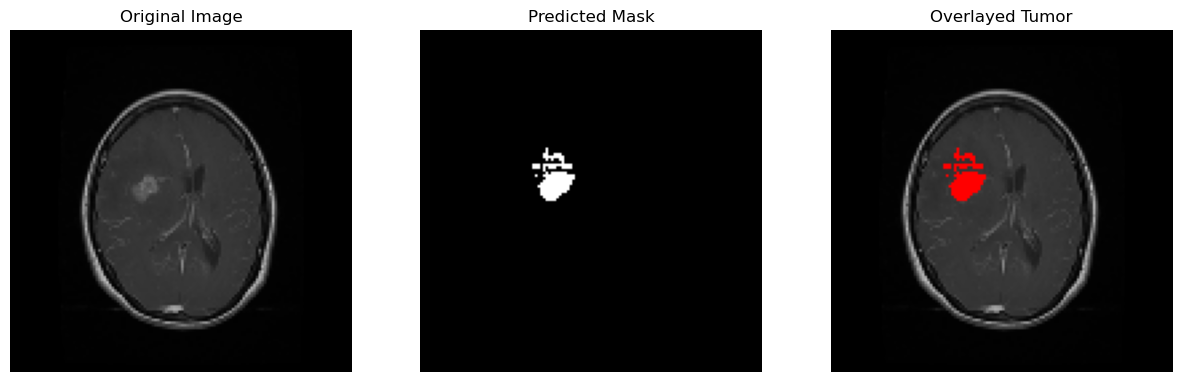

In [65]:
import matplotlib.pyplot as plt

# Test Prediction
def visualize_prediction(model, image, ground_truth_mask):
    pred_mask = model.predict(image[np.newaxis, ...])[0]  # Predict mask for the image
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Binarize the mask
    
    resized_mask = cv2.resize(pred_mask.squeeze(), (image.shape[1], image.shape[0]))
    
    # Prepare the original image
    original_image = (image.squeeze() * 255).astype(np.uint8)  # Denormalize to [0, 255]
    if len(original_image.shape) == 2:  # If grayscale, convert to RGB
        original_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2RGB)
    
    # Create a color overlay (tumor region in red)
    color_overlay = original_image.copy()
    color_overlay[resized_mask == 1] = [255, 0, 0]  # Tumor region highlighted in red
    
    # Visualize results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(resized_mask, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title("Overlayed Tumor")
    plt.imshow(color_overlay)
    plt.axis('off')
    
    plt.show()

# Example Usage
test_image = X_val[18]  # Replace with actual test image
ground_truth_mask =Y_val[18]  # Replace with actual mask
print(X_val.shape)
visualize_prediction(model, test_image, ground_truth_mask)


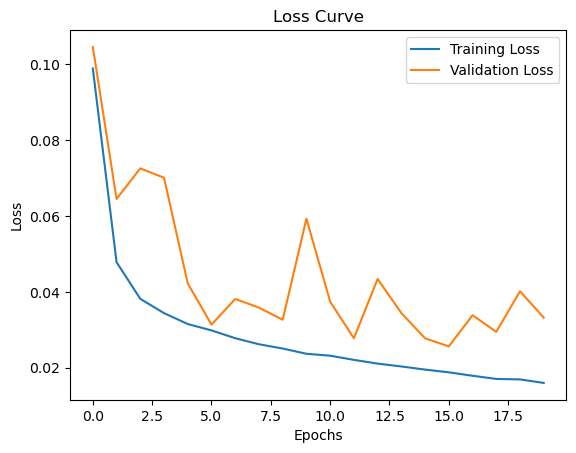

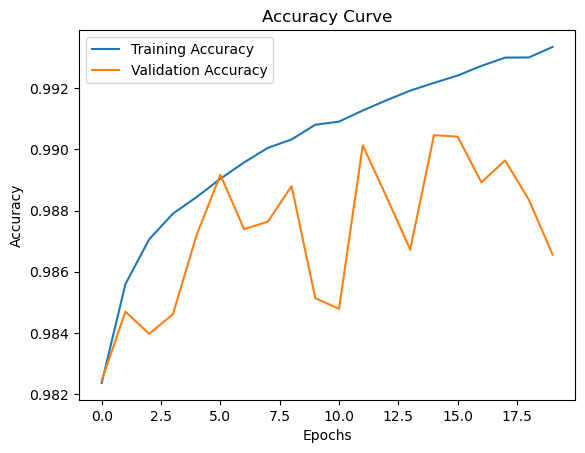

In [75]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()


In [73]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_val, Y_val)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step - accuracy: 0.9901 - loss: 0.0268
Test Loss: 0.02561594359576702
Test Accuracy: 0.9904206395149231
